# Stellar Proper Motion Analysis Using GAIA and AstroPy
*Author: Eric G. Suchanek, Ph.D. 3/27/19 v0.3*

This notebook creates a list stars centered on the Pelican Nebula and displays some aspects of their
of their proper motion in an effort to identify co-migrating stars. It uses 
direct queries to the GAIA database to retrieve the stellar data. matplotlib is used 
to plot the results.

The notebook is meant to be pedagogical and shows various methods of manipulating 
the data structures used. Consequently, the code is not optimized and will be 
slow when working with a large search area, (resuting in large number of stars)!

Personal note: The Python modules used provide extensive functionality beyond that
shown here. I encourage the reader to look at the AstroPy and AstroQuery documentation. 
AstroQuery is particulary powerful and provides easy access to most modern astronomical catalogues. 
Coupled with AstroPy it is now possible to execute sophisticated queries across most modern catalogues,
and perform meaningful analysis easily and quickly. 

The code blocks here may be used freely under the GNU public use license and are quite general 
and easily extended.


### Useful Links
* Gaia search interface: https://gea.esac.esa.int/archive/
* Gaia DR2 data model: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/
* AstroPy documentation: https://astropy.readthedocs.io/en/latest/
* Using SkyCoords: http://docs.astropy.org/en/stable/coordinates/skycoord.html#array-operations
* AstroQuery documentation: https://astroquery.readthedocs.io/en/latest/
* AstroQuery source list: https://astroquery.readthedocs.io/en/latest/#available-services
* Gallery of AstroQuery queries: https://astroquery.readthedocs.io/en/latest/gallery.html
* ADQL Cookbook: https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook
* Mixed Table manipulation: http://docs.astropy.org/en/stable/table/access_table.html
* Gaia class definiation: https://astroquery.readthedocs.io/en/latest/api/astroquery.gaia.GaiaClass.html#astroquery.gaia.GaiaClass.cone_search_async
* Working with velocities in AstroPy: http://docs.astropy.org/en/stable/coordinates/velocities.html#radial-velocity-corrections
* aplpy documentation: https://aplpy.readthedocs.io/en/stable/fitsfigure/quick_reference.html
* working with tables in astropy: http://docs.astropy.org/en/stable/table/access_table.html

In [1]:
#
# Setup the libraries. In general grab all of these
#
%matplotlib inline
import astropy.units as u
import astropy.coordinates as coord

from astropy.coordinates import SkyCoord, Galactic, ICRS
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.visualization import astropy_mpl_style, quantity_support

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import numpy as np
import time
import progressbar

from mirapy import egs

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# enable quantity support
quantity_support()  

# use fancy Astronomy-style plotting
plt.style.use(astropy_mpl_style)

# Here are the primary global parameters. size = the circle or rectangle size, error_cutoff is the % error in 
# proper motion that we want to use as maximum acceptable error

size = 1*u.deg # remember to cast into the correct units!
error_cutoff = 1 # < x relative error cutoff to keep. 1 means take all, .1 only best 10%

# ADQL select strings to do a direct query to the GAIA database.
# It takes parameters of ra, dec circle_radius, ra_error, dec_error 
# as input and results in a valid ADQL query that can be sent to GAIA via TAP+

#
# ADQL query string template for circular query
#

sel_str_circle = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1 \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL \
AND gaia_source.parallax IS NOT NULL ;"
#
# ADQL query string template for rectangular query
#

sel_str_box = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,\
gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND abs(gaia_source.pmra_error/gaia_source.pmra)<{} \
AND abs(gaia_source.pmdec_error/gaia_source.pmdec)<{} \
AND gaia_source.pmra IS NOT NULL AND \
AND gaia_source.pmdec IS NOT NULL ;"

sel_str_box_all = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.pmra IS NOT NULL AND abs(gaia_source.pmra)>0 \
AND gaia_source.pmdec IS NOT NULL AND abs(gaia_source.pmdec)>0;"

from mirapy import *

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


*For this example we use the Pelican Nebula as center, and select all stars within 1 degree. One has to pass coordinates using the SkyCoord type, in the ICRS coordinate frame. The 'job' object returned by the Gaia searches contain the stars satisfying this initial center and radius. These queries can take minutes or more to run. The timings indicated were conducted
on a 2014 MacBook Pro, 2.5 GHz i7, 16 GB RAM, over a wireless connection.*

In [3]:
#
# Here's the block that actually queries the GAIA database based on our object center 
# and desired pmra and pmdec accuracy.
# the variable 'stars' is assigned to the query result
#

#312.708333,44.3208333,0.2666667

"""
pel_ra = 20.8467 * 15 # convert to degrees!
pel_dec = 44.35

"""
pel_ra = 312.708333
pel_dec = 44.3208333
size = .2666667 * u.deg

error_cutoff = 1 # take all stars with relative error < 1
#size = .5*u.deg # remember to cast into the correct units!

# Get the SkyCoord for the Pelican Nebula object coordinates
# hard way, convert to decimal by hand

# easy way, pass using hms string notation.
PelicanNebulaCoords = SkyCoord("20h50m48s 44d20m59s", frame='icrs')

print(PelicanNebulaCoords, "\n")

#
# if you want to use the SkyCoord coordinates you create the query string this way:
# query_box = sel_str_box.format(PelicanNebulaCoords.ra.value, 
#                   PelicanNebulaCoords.dec.value, size.value,size.value, error_cutoff, error_cutoff)

# since we know the coordinates we can pass directly to create the query string
# format the query string (rectangular search), with our parameters by using str.format() method

# query for stars constrained by relative error cutoff
q = sel_str_box.format(pel_ra, pel_dec, size.value,size.value, error_cutoff, error_cutoff)

# query for all stars, indpendent of pmra and pmdec errors
q2 = sel_str_box_all.format(pel_ra, pel_dec, size.value,size.value)

q3 = "SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',20.0914,50.9497,0.5))=1 AND pmra IS NOT NULL AND abs(pmra)>0 AND pmdec IS NOT NULL AND abs(pmdec)>0;"
# print the query to show the user how ugly it is
print("Here's the query we're sending: \n", q, "\n" )

start = time.time()

job = Gaia.launch_job_async(query=q3, dump_to_file=False, output_file="pelican_neb_1deg.csv",
                           output_format='csv')
# 'stars' is the global variable representing the initial query results
stars = job.get_results()

end = time.time()
print("Elapsed time was: ", end - start, " seconds")

# show a quick look at the results
# stars.pprint()
# print(stars.info())
# print('Search query returned ', len(stars), 'stars, with pmra and pmdec errors < ', error_cutoff)
print("Search query returned ", len(stars), " stars")


<SkyCoord (ICRS): (ra, dec) in deg
    (312.7, 44.34972222)> 

Here's the query we're sending: 
 SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',312.708333,44.3208333,0.2666667,0.2666667))=1 AND abs(gaia_source.pmra_error/gaia_source.pmra)<1 AND abs(gaia_source.pmdec_error/gaia_source.pmdec)<1 AND gaia_source.pmra IS NOT NULL AND AND gaia_source.pmdec IS NOT NULL ; 

Query finished.
Elapsed time was:  65.69169616699219  seconds
Search query returned  17961  stars


Now plot the RA and DEC proper motion. We use figures and subplots since this notebook has several plots

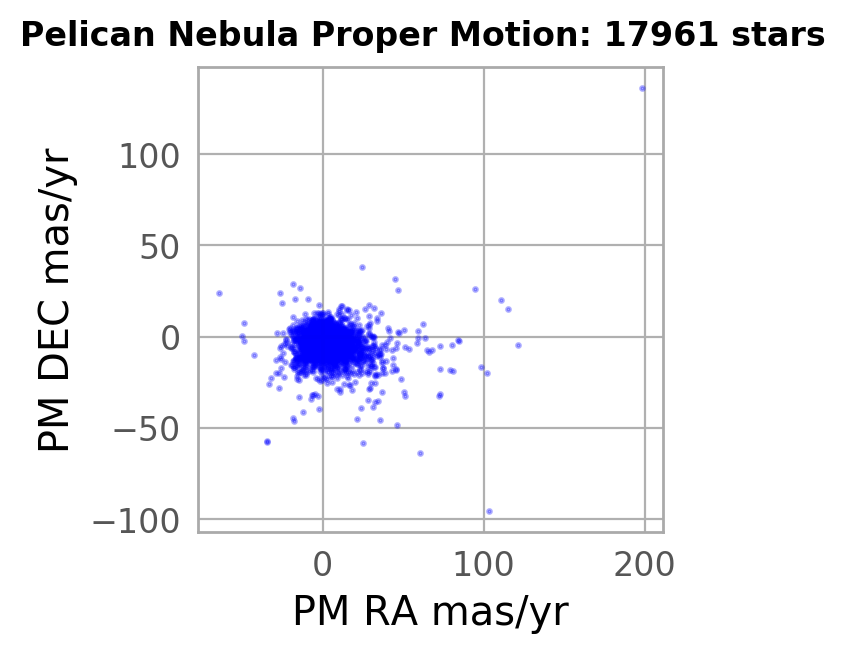

In [4]:
fig, ax = plt.subplots(figsize=(3,3),dpi=200)

ax.scatter(stars['pmra'], stars['pmdec'], color='b', alpha=0.3, s=2)

fig.subplots_adjust(top=0.90)
fig.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
             fontsize=12, fontweight='bold')
# ax.set_title('axes title')
ax.set_xlabel('PM RA mas/yr')
ax.set_ylabel('PM DEC mas/yr')

plt.show()
plt.close()


In [7]:
# find the maximum pm in ra and dec to scale the quiverkey
# take the absolute values to handle large negatives!

def determine_qkey_len(stars):
    #print(stars['pmra'])
    pmra_min = abs(np.min(stars['pmra']))
    pmra_max = abs(np.max(stars['pmra']))
    pmdec_min = abs(np.min(stars['pmdec']))
    pmdec_max = abs(np.max(stars['pmdec']))
    pm = [pmra_min, pmra_max, pmdec_min, pmdec_max]
    #print(pm)
    qk = int(max(pm)+.5)
    return(qk)



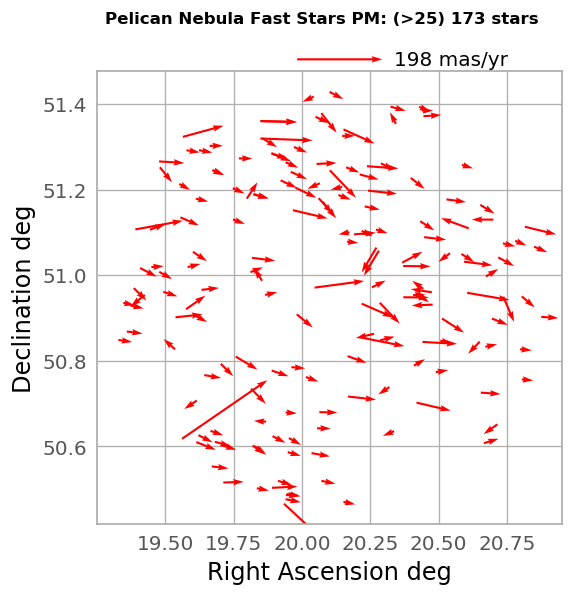

In [8]:
# 
# Now take a look at stars with high proper motion
# Pick a number for 'fast'
speedy = 25 # mas/yr

# Very useful reference for manipulating the tables in AstroPy:
# http://docs.astropy.org/en/stable/table/access_table.html
#
# Create a 'mask' that represents the stars whose pmra or pmdec >= speedy
# then create the new list based on this mask - use abs() to handle negatives

mask = (abs(stars['pmra']) >= speedy) | abs((stars['pmdec']) >= speedy)
faststars = stars[mask]

#
# Create a quiver plot of the stars, where the pmra and pmdec determine the 
# orientation of the arrows
#
fig2a, ax2a = plt.subplots(figsize=(5,5),dpi=120)
fig2a.suptitle('Pelican Nebula Fast Stars PM: (>' + str(speedy) + ') ' + str(len(faststars))+ ' stars', 
              fontsize=10, fontweight='bold')

ax2a.set_xlabel('Right Ascension deg')
ax2a.set_ylabel('Declination deg')

# This quiver plot requires 4 inputs: the X positions and Y positions for each 
# point and their U and V directions, (their proper motions in this case, 
# oriented relative to the RA and DEC axes) to get these, simply slice 
# the stars table along the proper columns to create the relevant array

Xf = faststars['ra']
Yf = faststars['dec']
Uf = faststars['pmra']
Vf = faststars['pmdec']

qk_len = determine_qkey_len(faststars)
qk_str = str(qk_len) + ' mas/yr'

quiver_plot_fast = ax2a.quiver(Xf, Yf, Uf, Vf, angles='uv', units='xy', color='r')
ax2a.quiverkey(quiver_plot_fast, X=0.6, Y=0.9, U=qk_len,
             label=qk_str, labelpos='E', coordinates='figure')

plt.show()

Next we create a quiver plot of all the stars' proper motions.

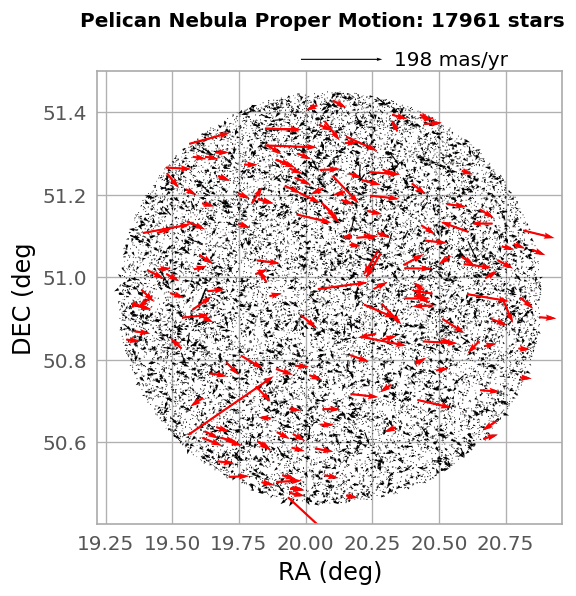

In [9]:
#
# Create a quiver plot of the stars, where the pmra and pmdec determine the 
# orientation of the arrows
#
fig2c, ax2c = plt.subplots(figsize=(5,5),dpi=120)
fig2c.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
              fontsize=12, fontweight='bold')

ax2c.set_xlabel('RA (deg)')
ax2c.set_ylabel('DEC (deg')

# determine the length of the quiverkey and make the string label
qk_len = determine_qkey_len(stars)
qk_str = str(qk_len) + ' mas/yr'

# This quiver plot requires 4 inputs: the X positions and Y positions for each 
# point and their U and V directions, (their proper motions in this case, 
# oriented relative to the RA and DEC axes) to get these, simply slice 
# the stars table along the proper columns to create the relevant array

X = stars['ra']
Y = stars['dec']
U = stars['pmra']
V = stars['pmdec']

quiver_plot = ax2c.quiver(X, Y, U, V, angles='uv', units='xy')
quiver_plot_fast = ax2c.quiver(Xf, Yf, Uf, Vf, angles='uv', units='xy', color='r')
ax2c.quiverkey(quiver_plot, X=0.6, Y=0.9, U=qk_len,
             label=qk_str, labelpos='E', coordinates='figure')

plt.show()

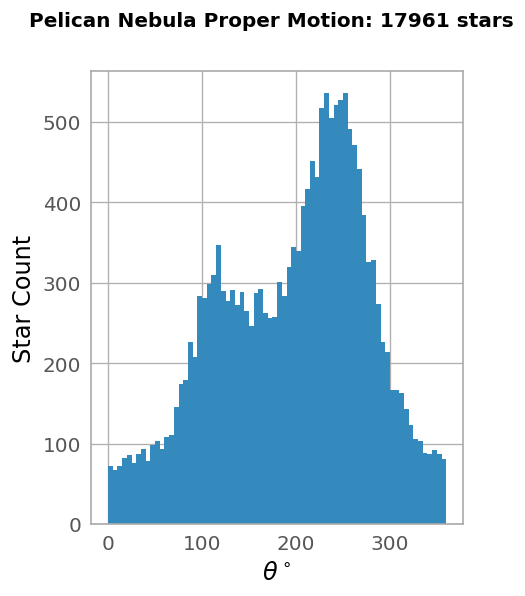

In [13]:
#
# Create a histogram plot of the stars, showing the distribution of the 
# PM angle (arctan(pmdec/pmdra))
#

fig3, ax3 = plt.subplots(figsize=(4,5),dpi=120)
fig3.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
              fontsize=12, fontweight='bold')

ax3.set_xlabel(r"$\theta^\circ$")
ax3.set_ylabel('Star Count')

to_deg = 180.0 / np.pi
n_bins = 72
x = []

x = egs.compute_pm_angles(stars)
ax3.hist(x, bins=n_bins)

plt.show()


# Now we'll look at the distribution

## Subroutines and Utility Functions

 [Elapsed Time: 0:02:17] |##################################| (Time:  0:02:17) 


Elapsed time was: 137.2224268913269 seconds


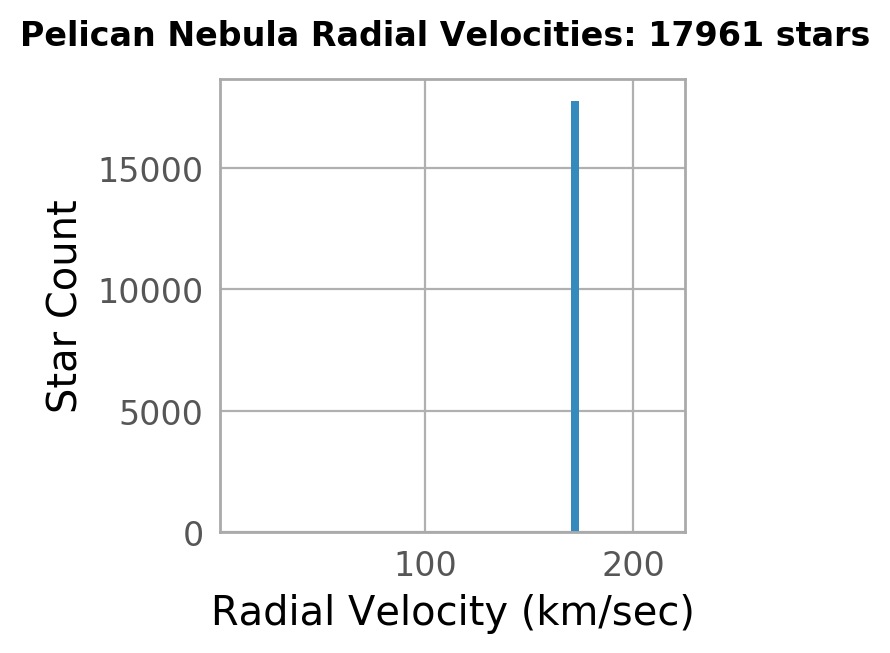

In [14]:
#
# Create a histogram plot of the stars' radial velocities
# 
#
fig4, ax4 = plt.subplots(figsize=(3,3),dpi=200)

ax4.set_xlabel('Radial Velocity (km/sec)')
ax4.set_ylabel('Star Count')

n_bins = 50

# convert radial velocity to GSR coordinate frame
# we have to convert each star into an ICRS object first in order
# to convert to GCRS via our function.

i = count = 0
vels = []

start = time.time()
vels = egs.get_radial_vals(stars)
end = time.time()
print("Elapsed time was: " + str(end - start) + " seconds")

fig4.suptitle('Pelican Nebula Radial Velocities: '+ str(len(vels)) + ' stars', 
              fontsize=12, fontweight='bold')
ax4.hist(vels, bins=n_bins)

plt.show()

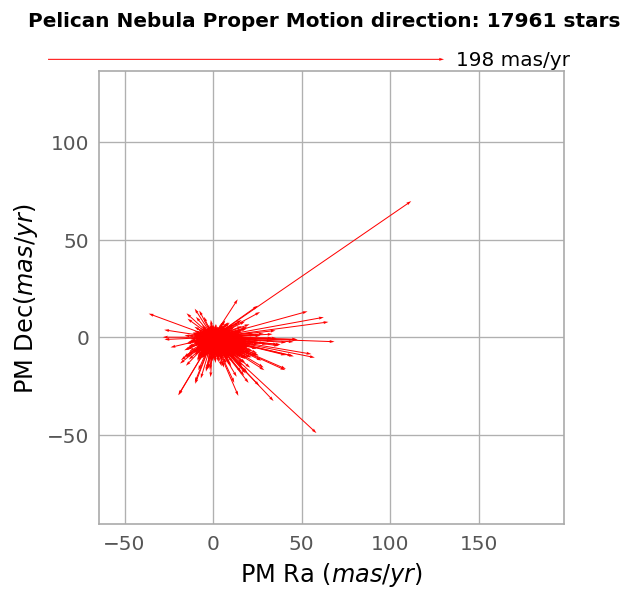

In [15]:
#
# Create a quiver plot of the stars, centered at the origin, where the pmra and pmdec determine the 
# orientation of the arrows
#
fig, ax = plt.subplots(figsize=(5,5),dpi=120)
fig.suptitle('Pelican Nebula Proper Motion direction: '+ str(len(stars))+ ' stars', 
              fontsize=12, fontweight='bold')

ax.set_xlabel('PM Ra ($mas/yr$)')
ax.set_ylabel('PM Dec($mas/yr$)')

# determine the length of the quiverkey and make the string label
qk_len = determine_qkey_len(stars)
qk_str = str(qk_len) + ' mas/yr'

# This quiver plot requires 4 inputs: the X positions and Y positions for each 
# point and their U and V directions, (their proper motions in this case, 
# oriented relative to the RA and DEC axes) to get these, simply slice 
# the stars table along the proper columns to create the relevant array

X = 0.0
Y = 0.0
U = stars['pmra']
V = stars['pmdec']

xmin = U.min()
xmax = U.max()
ymin = V.min()
ymax = V.max()
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

quiver_plot = ax.quiver(0,0, U, V, angles='uv', units='dots', color='r',width=1,scale=1.0)
ax.quiverkey(quiver_plot, X=0.7, Y=0.9, U=qk_len*2,
             label=qk_str, labelpos='E', coordinates='figure')

plt.show()

## End of Notebook. Thank you for reading, and may your queries yield new insights